In [ ]:
# Download dependencies
!pip install imgaug
!apt-get update && apt-get install -y python3-opencv
!pip install keras-flops
!pip install seaborn
!pip install privacy-meter
# download explanations.json from privacy meter

# Import libraries
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.layer_utils import count_params
from keras_flops import get_flops
import sys
import os
import random
from imgaug import augmenters as iaa
from privacy_meter.audit import Audit, MetricEnum
from privacy_meter.audit_report import ROCCurveReport, SignalHistogramReport, ConfusionMatrixReport
from privacy_meter.constants import InferenceGame
from privacy_meter.dataset import Dataset
from privacy_meter.information_source import InformationSource
from privacy_meter.model import TensorflowModel
from privacy_meter import audit_report

In [ ]:
# Import RAF-DB data set
X_train = np.load('rafdb/X_train_rafdb.npy')
Y_train = np.load('rafdb/Y_train_rafdb.npy')
X_dev = np.load('rafdb/X_val_rafdb.npy')
Y_dev = np.load('rafdb/Y_val_rafdb.npy')
X_test = np.load('rafdb/X_test_rafdb.npy')
Y_test = np.load('rafdb/Y_test_rafdb.npy')

print(X_train.shape, Y_train.shape)
print(X_dev.shape, Y_dev.shape)
print(X_test.shape, Y_test.shape)

(11043, 224, 224, 3) (11043, 7)
(1228, 224, 224, 3) (1228, 7)
(3068, 224, 224, 3) (3068, 7)


In [ ]:
# Experimental Settings and Dataset
learning_rate = 0.1
epochs = 30
batch_size = 4
num_train_points = 2000
num_population_points = X_train.shape[0]
fpr_tolerance_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

print('train points', num_train_points)

# split train as member set of audit and population set as ref data by PopulationMetrics
# partition 50%-50%
x_train, y_train = X_train[:num_train_points], Y_train[:num_train_points]
x_test, y_test = X_test[:num_train_points], Y_test[:num_train_points]
x_dev, y_dev = X_dev[:200], Y_dev[:200]
x_population, y_population = X_train[num_train_points:num_train_points*3], Y_train[num_train_points:num_train_points*3]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_dev.shape, y_dev.shape)
print(x_population.shape, y_population.shape)

# Setup dataset object

# create the target model's dataset
train_ds = {'x': x_train, 'y': y_train}
test_ds = {'x': x_test, 'y': y_test}
target_dataset = Dataset(
    data_dict={'train': train_ds, 'test': test_ds},
    default_input='x', default_output='y'
)

# create the reference dataset
population_ds = {'x': x_population, 'y': y_population}
reference_dataset = Dataset(
    # this is the default mapping that a Metric will look for
    # in a reference dataset
    data_dict={'train': population_ds},
    default_input='x', default_output='y'
)

train points 2000
(2000, 224, 224, 3) (2000, 7)
(2000, 224, 224, 3) (2000, 7)
(200, 224, 224, 3) (200, 7)
(4000, 224, 224, 3) (4000, 7)


In [ ]:
# image normalization
normalizer = tf.keras.layers.Normalization(axis=None)
normalizer.adapt(x_train)

2022-06-19 04:47:25.440564: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 04:47:25.499533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 04:47:25.499897: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 04:47:25.502007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-19 04:47:25.502428: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1052] successful NUMA node read f

<h6>GHOSTFACE</h6>

In [ ]:
# Triplet Attention Module
def TripletAttention(x, block_code):

    permute_hw = tf.keras.layers.Permute((1, 2, 3))(x)
    concat_hw = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_hw, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_hw, axis=-1), axis=-1)])
    conv_hw = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_hw)
    batchnorm_hw = tf.keras.layers.BatchNormalization()(conv_hw)
    sig_act_hw = tf.keras.layers.Activation('sigmoid')(batchnorm_hw)
    skipconn_hw = tf.keras.layers.Multiply()([sig_act_hw, permute_hw])

    permute_w = tf.keras.layers.Permute((1, 3, 2))(x)
    concat_w = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_w, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_w, axis=-1), axis=-1)])
    conv_w = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_w)
    batchnorm_w = tf.keras.layers.BatchNormalization()(conv_w)
    sig_act_w = tf.keras.layers.Activation('sigmoid')(batchnorm_w)
    skipconn_w = tf.keras.layers.Multiply()([sig_act_w, permute_w])
    repermute_w = tf.keras.layers.Permute((1, 3, 2))(skipconn_w)

    permute_h = tf.keras.layers.Permute((3, 1, 2), name= 'block' + str(block_code) + '_permute1_h')(x)
    concat_h = tf.keras.layers.Concatenate(axis=-1, name= 'block' + str(block_code) + '_concat_h')([tf.expand_dims(tf.math.reduce_max(permute_h, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_h, axis=-1), axis=-1)])
    conv_h = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last', name= 'block' + str(block_code) + '_conv_h')(concat_h)
    batchnorm_h = tf.keras.layers.BatchNormalization(name= 'block' + str(block_code) + '_batchnorm_h')(conv_h)
    sig_act_h = tf.keras.layers.Activation('sigmoid', name= 'block' + str(block_code) + '_sigmoid_h')(batchnorm_h)
    skipconn_h = tf.keras.layers.Multiply(name= 'block' + str(block_code) + '_mult_h')([sig_act_h, permute_h])
    repermute_h = tf.keras.layers.Permute((3, 2, 1), name= 'block' + str(block_code) + '_permute2_h')(skipconn_h)

    average_lyr = tf.keras.layers.Average(name='block' + str(block_code) + '_average')([skipconn_hw, repermute_w, repermute_h])
    return average_lyr

# Fused MB-Convolution Module
def fused_conv(x, block_num, filters, strides, attention=False):
    x1 = layers.Conv2D(filters=filters, kernel_size=3, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    if attention == True:
        x1 = TripletAttention(x1, block_num)

    x2 = layers.Conv2D(filters=filters, kernel_size=strides, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_2')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)

    if strides!=2:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
    else:
        x3 = x2
        
    return x3

# Ghost Module
def ghostnet_module(x, block_num, filters, kernel_size, strides=1, activation=True):
    x1 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu1')(x1)
    
    x2 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_dwconv_1')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    if activation==True:
        x2 = layers.Activation('relu', name='block'+str(block_num)+'_relu2')(x2)
    
    x3 = layers.Add(name='block'+str(block_num)+'_add')([x1, x2])
    return x3

# Attention GhostNet Bottleneck Module
def ghostnet_bottleneck(x, block_num, filters, strides, kernel_size=3):
          
    x1 = ghostnet_module(x, str(block_num) + '1', filters, kernel_size, strides=1, activation=True)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    x1 = TripletAttention(x1, block_num)
    
    x2 = ghostnet_module(x1, str(block_num) + '2', filters, kernel_size, strides=1, activation=False)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    
    b0, h0, w0, c0 = x2.shape 
    if strides>1:
        if c0!=filters*2:
            x = layers.DepthwiseConv2D(kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv_correction')(x)
            x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_conv_correction')(x)
        
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
        x3 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=2, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv1')(x3)
    else:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])

    return x3

# GHOSTFACE CLASSIFICATION MODEL 
def classification_model(input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rotation_range=40, horizontal_flip=True, 
                                   width_shift_range=0.40, height_shift_range=0.40)
datagen_train.fit(x_train)

In [ ]:
# training without any augmentation

x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.1, clipnorm=1.)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

model = classification_model()
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])

history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reduce_learning_rate, early_stopping])

2022-06-19 04:47:36.023186: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-19 04:47:37.599119: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/30


2022-06-19 04:48:03.586471: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 68s 82ms/step - loss: 1.6667 - accuracy: 0.3890 - val_loss: 1.6760 - val_accuracy: 0.3600 - lr: 0.1000
Epoch 2/30
500/500 [==============================] - 38s 76ms/step - loss: 1.6421 - accuracy: 0.3915 - val_loss: 1.7764 - val_accuracy: 0.3400 - lr: 0.1000
Epoch 3/30
500/500 [==============================] - 37s 74ms/step - loss: 1.6383 - accuracy: 0.3935 - val_loss: 1.7918 - val_accuracy: 0.3300 - lr: 0.1000
Epoch 4/30
500/500 [==============================] - 38s 75ms/step - loss: 1.6379 - accuracy: 0.3950 - val_loss: 1.6667 - val_accuracy: 0.3500 - lr: 0.1000
Epoch 5/30
500/500 [==============================] - 38s 76ms/step - loss: 1.6275 - accuracy: 0.3940 - val_loss: 1.7311 - val_accuracy: 0.3450 - lr: 0.1000
Epoch 6/30
500/500 [==============================] - 38s 76ms/step - loss: 1.6241 - accuracy: 0.3935 - val_loss: 1.7766 - val_accuracy: 0.3250 - lr: 0.1000
Epoch 7/30
500/500 [==============================] - 37s 74ms/step -

In [ ]:
# MIA attack - training without any augmentation
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)

2022-06-19 05:46:47.577638: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-19 05:46:56.125783: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-19 05:46:56.127751: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-19_05-46-47-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.50025
ROC AUC Score     = 0.50025
FPR               = 0.0005
TN, FP, FN, TP    = (1999, 1, 1998, 2)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.56425
ROC AUC Score     = 0.5642499999999999
FPR               = 0.1055
TN, FP, FN, TP    = (1789, 211, 1532, 468)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.59875
ROC AUC Score     = 0.5987499999999999
FPR               = 0.209
TN, FP, FN, TP    = (1582, 418, 1187, 813)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.6205
ROC AUC Score     = 0.6204999999999998
FPR               = 0.32
TN, FP, FN, TP    = (1360, 640, 878, 1122)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.627
ROC AUC Score     = 0.627
FPR               = 0.424
TN, FP, FN, TP    = (1152, 848, 644, 1356)
============= METRIC RESULT OBJECT ====

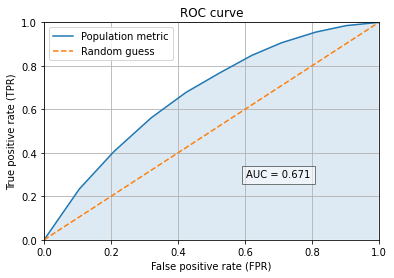

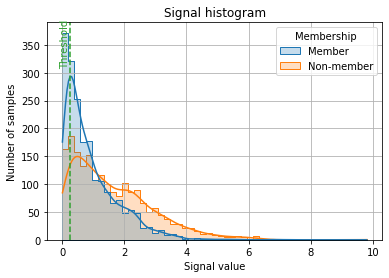

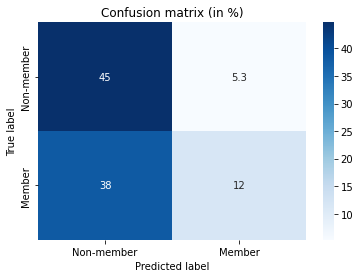

<Figure size 432x288 with 0 Axes>

In [ ]:
# MIA attack audit report - training without any augmentation
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

#<h6>1 guassian noise + no data augmentation</h6>

In [ ]:
# GhostFace with increase in regularization (gaussian noise layer)
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)

    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
# training without any augmentation + increase regularization (gaussian noise layer)
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

2022-06-14 14:26:11.563743: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-14 14:26:12.913403: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/25


2022-06-14 14:26:26.050461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 37s 46ms/step - loss: 1.6618 - accuracy: 0.3860 - val_loss: 2.2661 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6457 - accuracy: 0.3900 - val_loss: 3.1227 - val_accuracy: 0.3200 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 22s 43ms/step - loss: 1.6318 - accuracy: 0.3960 - val_loss: 2.0162 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 21s 43ms/step - loss: 1.6219 - accuracy: 0.3885 - val_loss: 3.9100 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6242 - accuracy: 0.3940 - val_loss: 1.8352 - val_accuracy: 0.3650 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 22s 43ms/step - loss: 1.6066 - accuracy: 0.3925 - val_loss: 1.9735 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 21s 42ms/step -

In [ ]:
# MIA attack - training without any augmentation + increase regularization (gaussian noise layer)
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])
audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

2022-06-14 14:35:16.427570: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-14 14:35:24.561842: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-14 14:35:24.561915: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-14_14-35-16-000']


In [ ]:
for result in audit_results:
    print(result)

============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.0
TN, FP, FN, TP    = (2000, 0, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.52825
ROC AUC Score     = 0.52825
FPR               = 0.109
TN, FP, FN, TP    = (1782, 218, 1669, 331)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.54075
ROC AUC Score     = 0.5407500000000001
FPR               = 0.209
TN, FP, FN, TP    = (1582, 418, 1419, 581)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5495
ROC AUC Score     = 0.5495
FPR               = 0.311
TN, FP, FN, TP    = (1378, 622, 1180, 820)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.55825
ROC AUC Score     = 0.55825
FPR               = 0.4185
TN, FP, FN, TP    = (1163, 837, 930, 1070)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.56725
ROC AUC Score     = 0.56725
FPR               = 0.5125
TN

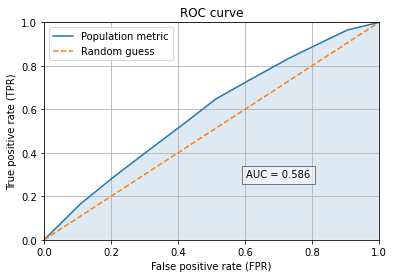

<Figure size 432x288 with 0 Axes>

In [ ]:
# MIA attack audit report - training without any augmentation + increase regularization (gaussian noise layer)
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )

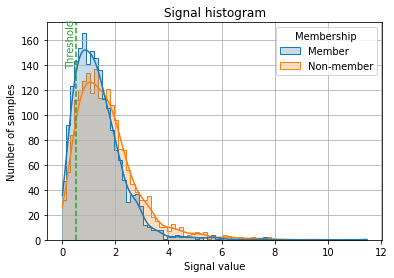

<Figure size 432x288 with 0 Axes>

In [ ]:
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

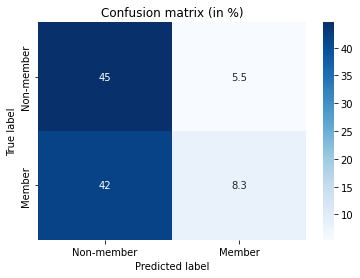

<Figure size 432x288 with 0 Axes>

In [ ]:
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

#<h6>1 gaussian noise + basic data augmentation</h6>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rotation_range=25, horizontal_flip=True, width_shift_range=0.25, height_shift_range=0.25)
datagen_train.fit(x_train)

In [ ]:
def TripletAttention(x, block_code):

    permute_hw = tf.keras.layers.Permute((1, 2, 3))(x)
    concat_hw = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_hw, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_hw, axis=-1), axis=-1)])
    conv_hw = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_hw)
    batchnorm_hw = tf.keras.layers.BatchNormalization()(conv_hw)
    sig_act_hw = tf.keras.layers.Activation('sigmoid')(batchnorm_hw)
    skipconn_hw = tf.keras.layers.Multiply()([sig_act_hw, permute_hw])

    permute_w = tf.keras.layers.Permute((1, 3, 2))(x)
    concat_w = tf.keras.layers.Concatenate(axis=-1)([tf.expand_dims(tf.math.reduce_max(permute_w, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_w, axis=-1), axis=-1)])
    conv_w = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last')(concat_w)
    batchnorm_w = tf.keras.layers.BatchNormalization()(conv_w)
    sig_act_w = tf.keras.layers.Activation('sigmoid')(batchnorm_w)
    skipconn_w = tf.keras.layers.Multiply()([sig_act_w, permute_w])
    repermute_w = tf.keras.layers.Permute((1, 3, 2))(skipconn_w)

    permute_h = tf.keras.layers.Permute((3, 1, 2), name= 'block' + str(block_code) + '_permute1_h')(x)
    concat_h = tf.keras.layers.Concatenate(axis=-1, name= 'block' + str(block_code) + '_concat_h')([tf.expand_dims(tf.math.reduce_max(permute_h, axis=-1), axis=-1), tf.expand_dims(tf.math.reduce_mean(permute_h, axis=-1), axis=-1)])
    conv_h = tf.keras.layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', data_format='channels_last', name= 'block' + str(block_code) + '_conv_h')(concat_h)
    batchnorm_h = tf.keras.layers.BatchNormalization(name= 'block' + str(block_code) + '_batchnorm_h')(conv_h)
    sig_act_h = tf.keras.layers.Activation('sigmoid', name= 'block' + str(block_code) + '_sigmoid_h')(batchnorm_h)
    skipconn_h = tf.keras.layers.Multiply(name= 'block' + str(block_code) + '_mult_h')([sig_act_h, permute_h])
    repermute_h = tf.keras.layers.Permute((3, 2, 1), name= 'block' + str(block_code) + '_permute2_h')(skipconn_h)

    average_lyr = tf.keras.layers.Average(name='block' + str(block_code) + '_average')([skipconn_hw, repermute_w, repermute_h])
    return average_lyr

def fused_conv(x, block_num, filters, strides, attention=False):
    x1 = layers.Conv2D(filters=filters, kernel_size=3, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    if attention == True:
        x1 = TripletAttention(x1, block_num)

    x2 = layers.Conv2D(filters=filters, kernel_size=strides, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_2')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)

    if strides!=2:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
    else:
        x3 = x2
        
    return x3

def ghostnet_module(x, block_num, filters, kernel_size, strides=1, activation=True):
    x1 = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_conv_1')(x)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu1')(x1)
    
    x2 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same', use_bias=False, name='block'+str(block_num)+'_dwconv_1')(x1)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    if activation==True:
        x2 = layers.Activation('relu', name='block'+str(block_num)+'_relu2')(x2)
    
    x3 = layers.Add(name='block'+str(block_num)+'_add')([x1, x2])
    return x3

def ghostnet_bottleneck(x, block_num, filters, strides, kernel_size=3):
          
    x1 = ghostnet_module(x, str(block_num) + '1', filters, kernel_size, strides=1, activation=True)
    x1 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_1')(x1)
    x1 = layers.Activation('relu', name='block'+str(block_num)+'_relu_1')(x1)
    
    x1 = TripletAttention(x1, block_num)
    
    x2 = ghostnet_module(x1, str(block_num) + '2', filters, kernel_size, strides=1, activation=False)
    x2 = layers.BatchNormalization(name='block'+str(block_num)+'_batchnorm_2')(x2)
    
    b0, h0, w0, c0 = x2.shape 
    if strides>1:
        if c0!=filters*2:
            x = layers.DepthwiseConv2D(kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv_correction')(x)
            x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_conv_correction')(x)
        
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])
        x3 = layers.DepthwiseConv2D(kernel_size=kernel_size, strides=2, padding='same', use_bias=False, name='block'+str(block_num)+'_downsample_dwconv1')(x3)
    else:
        x3 = layers.Add(name='block'+str(block_num)+'_add')([x, x2])

    return x3

def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    # x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    # x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

2022-06-14 14:42:49.202565: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-14 14:42:50.532007: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/25


2022-06-14 14:43:03.162241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 37s 47ms/step - loss: 1.6661 - accuracy: 0.3795 - val_loss: 1.8527 - val_accuracy: 0.3800 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 21s 41ms/step - loss: 1.6407 - accuracy: 0.3915 - val_loss: 2.1182 - val_accuracy: 0.3050 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6277 - accuracy: 0.3890 - val_loss: 1.6851 - val_accuracy: 0.3350 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6220 - accuracy: 0.3885 - val_loss: 1.7218 - val_accuracy: 0.3150 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6248 - accuracy: 0.3910 - val_loss: 1.7039 - val_accuracy: 0.3100 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 22s 44ms/step - loss: 1.6191 - accuracy: 0.3875 - val_loss: 1.7230 - val_accuracy: 0.3050 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 21s 43ms/step -

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)

2022-06-14 14:54:31.941614: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-14 14:54:40.483287: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-14 14:54:40.483354: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-14_14-54-31-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.4995
ROC AUC Score     = 0.4995
FPR               = 0.001
TN, FP, FN, TP    = (1998, 2, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5115
ROC AUC Score     = 0.5115
FPR               = 0.0955
TN, FP, FN, TP    = (1809, 191, 1763, 237)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.51775
ROC AUC Score     = 0.51775
FPR               = 0.2
TN, FP, FN, TP    = (1600, 400, 1529, 471)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5305
ROC AUC Score     = 0.5305000000000001
FPR               = 0.293
TN, FP, FN, TP    = (1414, 586, 1292, 708)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.53425
ROC AUC Score     = 0.53425
FPR               = 0.4035
TN, FP, FN, TP    = (1193, 807, 1056, 944)
============= METRIC RESULT OBJECT =============
Accuracy     

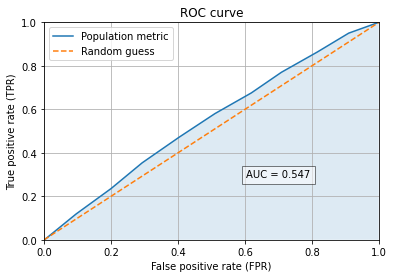

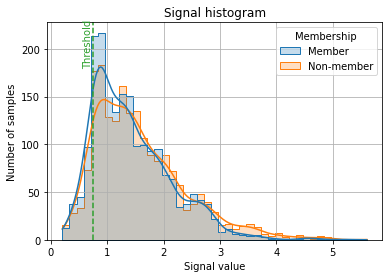

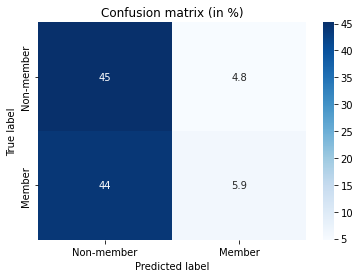

<Figure size 432x288 with 0 Axes>

In [ ]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

#**<h6>1 gaussian noise + randaug</h6>**

In [ ]:
def rand_augmentation(X_train_kaug, Y_train_kaug):
    print(X_train_kaug.shape, Y_train_kaug.shape)
    rand_aug = iaa.RandAugment(n=(0, 2), m=(2, 6))
    X_train_kaug = rand_aug(images=X_train_kaug.astype('uint8')).astype('float32')
    print(X_train_kaug.dtype, Y_train_kaug.dtype)
    return X_train_kaug, Y_train_kaug

In [ ]:
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

x, y = rand_augmentation(x, y)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

(2000, 224, 224, 3) (2000, 7)
float32 float32


2022-06-15 13:50:14.055591: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-15 13:50:15.533233: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/25


2022-06-15 13:50:29.310743: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


499/500 [============================>.] - ETA: 0s - loss: 1.6758 - accuracy: 0.3888

2022-06-15 13:50:53.766481: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120422400 exceeds 10% of free system memory.


500/500 [==============================] - 40s 48ms/step - loss: 1.6750 - accuracy: 0.3890 - val_loss: 1.7104 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6395 - accuracy: 0.3900 - val_loss: 1.6822 - val_accuracy: 0.3550 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 22s 45ms/step - loss: 1.6418 - accuracy: 0.3920 - val_loss: 1.6870 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 21s 43ms/step - loss: 1.6321 - accuracy: 0.3920 - val_loss: 1.6653 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6313 - accuracy: 0.3955 - val_loss: 1.6850 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 21s 43ms/step - loss: 1.6272 - accuracy: 0.3900 - val_loss: 1.6570 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 21s 41ms/step -

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)

2022-06-15 13:59:34.225645: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-15 13:59:34.225718: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-15_13-59-25-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.0
TN, FP, FN, TP    = (2000, 0, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.507
ROC AUC Score     = 0.507
FPR               = 0.0855
TN, FP, FN, TP    = (1829, 171, 1801, 199)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.51675
ROC AUC Score     = 0.51675
FPR               = 0.2005
TN, FP, FN, TP    = (1599, 401, 1532, 468)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.52175
ROC AUC Score     = 0.5217499999999999
FPR               = 0.2975
TN, FP, FN, TP    = (1405, 595, 1318, 682)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5175
ROC AUC Score     = 0.5175
FPR               = 0.404
TN, FP, FN, TP    = (1192, 808, 1122, 878)
============= METRIC RESULT OBJECT =============
Accuracy          = 0

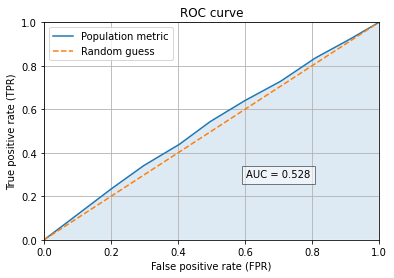

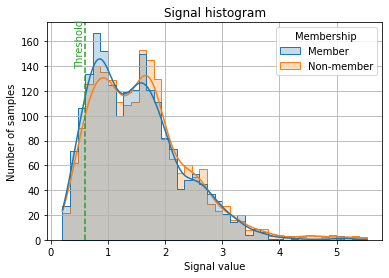

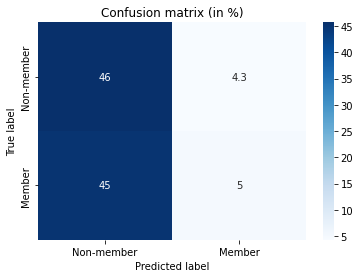

96/96 [==============================] - 5s 31ms/step - loss: 1.5633 - accuracy: 0.4061


0.40612778067588806

<Figure size 432x288 with 0 Axes>

In [ ]:

from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

loss, acc = model.evaluate(X_test, Y_test)
acc

#<h6>1 gaussian noise + mixup</h6>

In [ ]:
# function: MixUp
import random
def shuffle(X_train_mixup, Y_train_mixup):
    zipped = zip(X_train_mixup, Y_train_mixup)
    zip_list = list(zipped)
    random.shuffle(zip_list)
    
    imgs = [zip_list[i][0] for i in range(X_train_mixup.shape[0])]
    x_shuffled_mixup = np.asarray(imgs)

    lbls = [zip_list[i][1] for i in range(X_train_mixup.shape[0])]
    y_shuffled_mixup = np.asarray(lbls)

    print(x_shuffled_mixup.shape, y_shuffled_mixup.shape)
    
    return x_shuffled_mixup, y_shuffled_mixup

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(x_train_ds_1, y_train_ds_1, alpha=0.20):
    
    s = shuffle(x_train_ds_1, y_train_ds_1)
    batch_size = tf.shape(x_train_ds_1)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = x_train_ds_1 * x_l + s[0] * (1 - x_l)
    labels = y_train_ds_1 * y_l + s[1] * (1 - y_l)
    return images, labels

x_train[:1500], y_train[:1500] = mix_up(x_train[:1500], y_train[:1500])

In [ ]:
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

Epoch 1/25


2022-06-16 05:30:07.497609: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 41s 52ms/step - loss: 1.6770 - accuracy: 0.3850 - val_loss: 2.0016 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 23s 45ms/step - loss: 1.6417 - accuracy: 0.3885 - val_loss: 2.2692 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 23s 46ms/step - loss: 1.6462 - accuracy: 0.3910 - val_loss: 4.9617 - val_accuracy: 0.3500 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 22s 45ms/step - loss: 1.6406 - accuracy: 0.3920 - val_loss: 2.7266 - val_accuracy: 0.2750 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 23s 45ms/step - loss: 1.6325 - accuracy: 0.3925 - val_loss: 2.0311 - val_accuracy: 0.3300 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 23s 46ms/step - loss: 1.6445 - accuracy: 0.3885 - val_loss: 2.3641 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 23s 45ms/step -

2022-06-16 05:39:50.235542: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-16 05:39:50.235618: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-16_05-39-42-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.49975
ROC AUC Score     = 0.49975
FPR               = 0.0005
TN, FP, FN, TP    = (1999, 1, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.50225
ROC AUC Score     = 0.50225
FPR               = 0.1065
TN, FP, FN, TP    = (1787, 213, 1778, 222)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.512
ROC AUC Score     = 0.512
FPR               = 0.1925
TN, FP, FN, TP    = (1615, 385, 1567, 433)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.509
ROC AUC Score     = 0.509
FPR               = 0.2895
TN, FP, FN, TP    = (1421, 579, 1385, 615)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5325
ROC AUC Score     = 0.5325
FPR               = 0.3855
TN, FP, FN, TP    = (1229, 771, 1099, 901)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.53

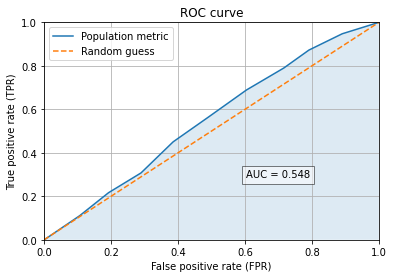

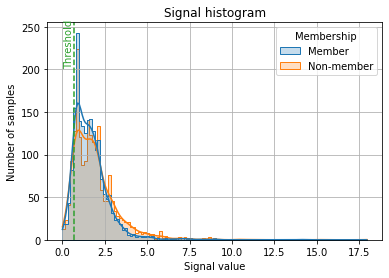

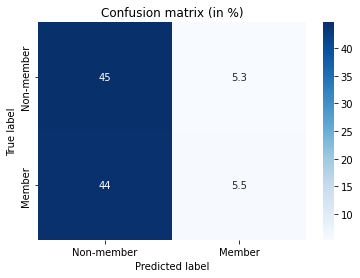

63/63 [==============================] - 4s 28ms/step - loss: 1.9028 - accuracy: 0.3490


0.3490000069141388

<Figure size 432x288 with 0 Axes>

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)
    
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

loss, acc = model.evaluate(x_test, y_test)
acc

#<h6>2 gaussian noise + no data augmentation</h6>

In [ ]:
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)

    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

2022-06-14 16:30:52.863818: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-14 16:30:53.960165: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/25


2022-06-14 16:31:08.196249: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 44s 57ms/step - loss: 1.6708 - accuracy: 0.3880 - val_loss: 1.7313 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 25s 50ms/step - loss: 1.6457 - accuracy: 0.3950 - val_loss: 1.7683 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 26s 52ms/step - loss: 1.6352 - accuracy: 0.3905 - val_loss: 1.6497 - val_accuracy: 0.3700 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 27s 54ms/step - loss: 1.6248 - accuracy: 0.3920 - val_loss: 1.7347 - val_accuracy: 0.3550 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 26s 52ms/step - loss: 1.6330 - accuracy: 0.3950 - val_loss: 1.6716 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 26s 52ms/step - loss: 1.6269 - accuracy: 0.3920 - val_loss: 1.6673 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 26s 52ms/step -

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)

2022-06-14 16:41:57.311262: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Results are stored in: ['/notebooks/log_2022-06-14_16-41-57-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.0005
TN, FP, FN, TP    = (1999, 1, 1999, 1)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.50525
ROC AUC Score     = 0.50525
FPR               = 0.11
TN, FP, FN, TP    = (1780, 220, 1759, 241)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.50725
ROC AUC Score     = 0.50725
FPR               = 0.2035
TN, FP, FN, TP    = (1593, 407, 1564, 436)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.511
ROC AUC Score     = 0.511
FPR               = 0.293
TN, FP, FN, TP    = (1414, 586, 1370, 630)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.514
ROC AUC Score     = 0.5139999999999999
FPR               = 0.398
TN, FP, FN, TP    = (1204, 796, 1148, 852)
============= METRIC RESULT OBJECT =============
Accuracy          = 0

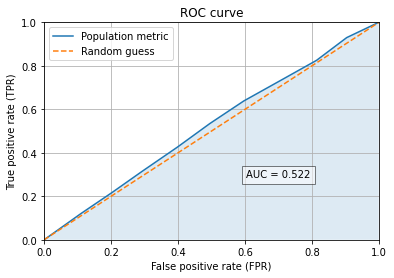

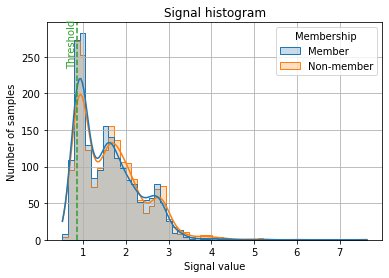

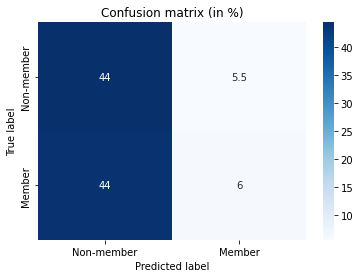

<Figure size 432x288 with 0 Axes>

In [ ]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

In [ ]:
loss, acc = model.evaluate(X_test, Y_test)
acc

96/96 [==============================] - 3s 30ms/step - loss: 1.6302 - accuracy: 0.3833


0.38331159949302673

#<h6>2 gaussian noise + basic data augmentation</h6>

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(rotation_range=25, horizontal_flip=True, 
                                   width_shift_range=0.25, height_shift_range=0.25)
datagen_train.fit(x_train)

In [ ]:
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)

    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

2022-06-15 07:09:03.974204: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-15 07:09:05.436331: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/25


2022-06-15 07:09:19.539149: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


499/500 [============================>.] - ETA: 0s - loss: 1.6797 - accuracy: 0.3868

2022-06-15 07:09:44.652673: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 120422400 exceeds 10% of free system memory.


500/500 [==============================] - 42s 53ms/step - loss: 1.6795 - accuracy: 0.3865 - val_loss: 1.7475 - val_accuracy: 0.3650 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 23s 45ms/step - loss: 1.6494 - accuracy: 0.3920 - val_loss: 2.5180 - val_accuracy: 0.3100 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 23s 46ms/step - loss: 1.6379 - accuracy: 0.3955 - val_loss: 1.7367 - val_accuracy: 0.3550 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 23s 47ms/step - loss: 1.6355 - accuracy: 0.3940 - val_loss: 4.1760 - val_accuracy: 0.2750 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 23s 46ms/step - loss: 1.6333 - accuracy: 0.3930 - val_loss: 1.8414 - val_accuracy: 0.3400 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 23s 46ms/step - loss: 1.6373 - accuracy: 0.3950 - val_loss: 2.9599 - val_accuracy: 0.2950 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 23s 46ms/step -

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)

2022-06-15 07:19:48.395485: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-15 07:19:48.395564: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-15_07-19-40-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.49975
ROC AUC Score     = 0.49975
FPR               = 0.0005
TN, FP, FN, TP    = (1999, 1, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5095
ROC AUC Score     = 0.5095000000000001
FPR               = 0.089
TN, FP, FN, TP    = (1822, 178, 1784, 216)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.52
ROC AUC Score     = 0.52
FPR               = 0.185
TN, FP, FN, TP    = (1630, 370, 1550, 450)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.517
ROC AUC Score     = 0.517
FPR               = 0.2945
TN, FP, FN, TP    = (1411, 589, 1343, 657)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.51575
ROC AUC Score     = 0.51575
FPR               = 0.4
TN, FP, FN, TP    = (1200, 800, 1137, 863)
============= METRIC RESULT OBJECT =============
Accuracy          =

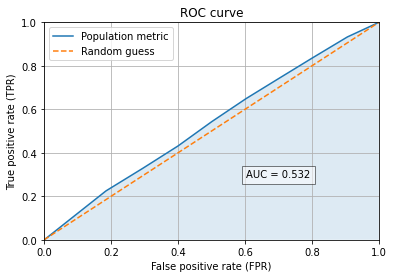

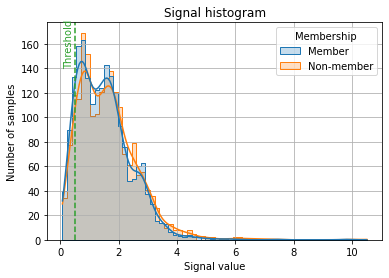

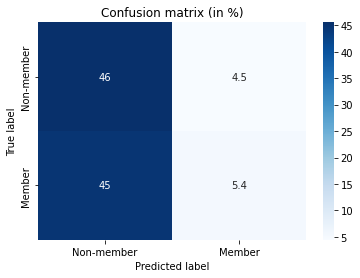

<Figure size 432x288 with 0 Axes>

In [ ]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

#<h6>2 gaussian noise + randaug</h6>

In [ ]:
def rand_augmentation(X_train_kaug, Y_train_kaug):
    print(X_train_kaug.shape, Y_train_kaug.shape)
    rand_aug = iaa.RandAugment(n=(0, 2), m=(2, 6)) 
    X_train_kaug = rand_aug(images=X_train_kaug.astype('uint8')).astype('float32')
    print(X_train_kaug.dtype, Y_train_kaug.dtype)
    return X_train_kaug, Y_train_kaug

In [ ]:
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

x, y = rand_augmentation(x, y)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

(2000, 224, 224, 3) (2000, 7)
float32 float32


2022-06-15 14:53:32.248673: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-15 14:53:33.623262: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.


Epoch 1/25


2022-06-15 14:53:46.937423: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 39s 47ms/step - loss: 1.6620 - accuracy: 0.3850 - val_loss: 1.7265 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 21s 41ms/step - loss: 1.6438 - accuracy: 0.3920 - val_loss: 2.7993 - val_accuracy: 0.2700 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 21s 43ms/step - loss: 1.6425 - accuracy: 0.3915 - val_loss: 1.6982 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 21s 43ms/step - loss: 1.6268 - accuracy: 0.3885 - val_loss: 1.7774 - val_accuracy: 0.3600 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 21s 43ms/step - loss: 1.6370 - accuracy: 0.3935 - val_loss: 1.6853 - val_accuracy: 0.3250 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 21s 42ms/step - loss: 1.6250 - accuracy: 0.3925 - val_loss: 1.7201 - val_accuracy: 0.3450 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 22s 44ms/step -

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)

2022-06-15 15:02:43.929085: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1204224000 exceeds 10% of free system memory.
2022-06-15 15:02:52.165248: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-15 15:02:52.165317: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-15_15-02-43-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.0
TN, FP, FN, TP    = (2000, 0, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.50275
ROC AUC Score     = 0.50275
FPR               = 0.1105
TN, FP, FN, TP    = (1779, 221, 1768, 232)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.504
ROC AUC Score     = 0.504
FPR               = 0.211
TN, FP, FN, TP    = (1578, 422, 1562, 438)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.51125
ROC AUC Score     = 0.51125
FPR               = 0.3
TN, FP, FN, TP    = (1400, 600, 1355, 645)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.515
ROC AUC Score     = 0.515
FPR               = 0.4025
TN, FP, FN, TP    = (1195, 805, 1135, 865)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.51625
ROC AUC S

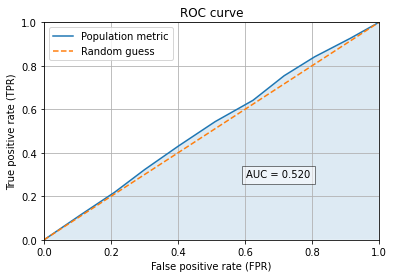

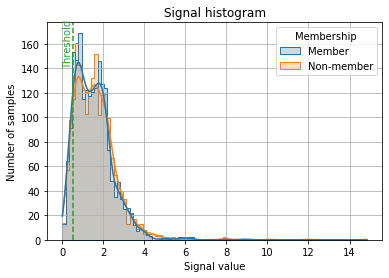

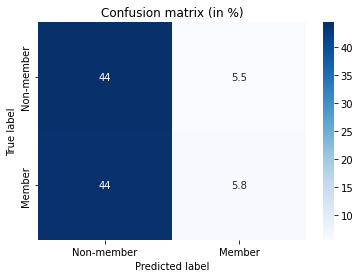

96/96 [==============================] - 5s 25ms/step - loss: 1.6044 - accuracy: 0.4012


0.4012385904788971

<Figure size 432x288 with 0 Axes>

In [ ]:
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

loss, acc = model.evaluate(X_test, Y_test)
acc

#<h6>2 gaussian noise + mixup</h6>

In [ ]:
import random
def shuffle(X_train_mixup, Y_train_mixup):
    zipped = zip(X_train_mixup, Y_train_mixup)
    zip_list = list(zipped)
    random.shuffle(zip_list)
    
    imgs = [zip_list[i][0] for i in range(X_train_mixup.shape[0])]
    x_shuffled_mixup = np.asarray(imgs)

    lbls = [zip_list[i][1] for i in range(X_train_mixup.shape[0])]
    y_shuffled_mixup = np.asarray(lbls)

    print(x_shuffled_mixup.shape, y_shuffled_mixup.shape)
    
    return x_shuffled_mixup, y_shuffled_mixup

def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)


def mix_up(x_train_ds_1, y_train_ds_1, alpha=0.20):
    
    s = shuffle(x_train_ds_1, y_train_ds_1)
    batch_size = tf.shape(x_train_ds_1)[0]

    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(batch_size, alpha, alpha)
    x_l = tf.reshape(l, (batch_size, 1, 1, 1))
    y_l = tf.reshape(l, (batch_size, 1))

    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = x_train_ds_1 * x_l + s[0] * (1 - x_l)
    labels = y_train_ds_1 * y_l + s[1] * (1 - y_l)
    return images, labels

x_train[:1500], y_train[:1500] = mix_up(x_train[:1500], y_train[:1500])

(1500, 224, 224, 3) (1500, 7)


2022-06-16 05:29:44.464247: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 903168000 exceeds 10% of free system memory.
2022-06-16 05:29:45.548395: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 903168000 exceeds 10% of free system memory.
2022-06-16 05:29:46.614538: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 903168000 exceeds 10% of free system memory.


<h6>2 gaussian noise + mixup</h6>

In [ ]:
def classification_model(noise, input_shape=(224, 224, 3)):
    input_lyr = tf.keras.layers.Input(input_shape)
    
    norm = normalizer(input_lyr)
    
    x = layers.Conv2D(filters=8, kernel_size=5, strides=2, padding='same', 
                      use_bias=False, name='normal_conv_1', data_format="channels_last")(norm)
    
    x = layers.BatchNormalization(name='normal_bn_1')(x)
    x = layers.Activation('relu', name='normal_relu')(x)
    
    x = fused_conv(x=x, block_num=1, filters=8, strides=1)
    x = fused_conv(x=x, block_num=2, filters=8, strides=1)
    x = fused_conv(x=x, block_num=3, filters=8, strides=1, attention=True)
    
    x = fused_conv(x=x, block_num=4, filters=16, strides=2, attention=True)
    x = fused_conv(x=x, block_num=5, filters=16, strides=1)
    x = fused_conv(x=x, block_num=6, filters=16, strides=1, attention=True)
    
    x = ghostnet_bottleneck(x=x, block_num=7, filters=16, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=8, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=9, filters=16, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=10, filters=16, kernel_size=3, strides=1)
    
    x = ghostnet_bottleneck(x=x, block_num=11, filters=32, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=12, filters=32, kernel_size=3, strides=1)
    x = ghostnet_bottleneck(x=x, block_num=13, filters=32, kernel_size=3, strides=1)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    x = ghostnet_bottleneck(x=x, block_num=14, filters=64, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=15, filters=128, kernel_size=3, strides=2)
    x = ghostnet_bottleneck(x=x, block_num=16, filters=240, kernel_size=3, strides=2)
    x = tf.keras.layers.GaussianNoise(stddev=noise)(x)
    
    # Classifier
    gap = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
    dense_layer_1 = layers.Dense(240, name='fc1')(gap)
    emotion_classifier = layers.Dense(7, name='classifier')(dense_layer_1)
    model = tf.keras.Model(inputs=input_lyr, outputs = emotion_classifier)
    return model

In [ ]:
x = target_dataset.get_feature('train', '<default_input>')
y = target_dataset.get_feature('train', '<default_output>')

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optim_fn = tf.keras.optimizers.SGD(learning_rate=0.01)
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=5, mode='min', cooldown=1)

model = classification_model(noise=0.1)
model.compile(optimizer=optim_fn, loss=loss_fn, metrics=['accuracy'])
history = model.fit(x, y, batch_size=batch_size, epochs=epochs, validation_data=(x_dev, y_dev), callbacks=[reducelr], shuffle=True)

Epoch 1/25


2022-06-16 05:17:44.129565: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


500/500 [==============================] - 41s 51ms/step - loss: 1.6503 - accuracy: 0.3890 - val_loss: 1.8808 - val_accuracy: 0.3400 - lr: 0.0100
Epoch 2/25
500/500 [==============================] - 24s 48ms/step - loss: 1.6302 - accuracy: 0.3945 - val_loss: 1.7588 - val_accuracy: 0.3550 - lr: 0.0100
Epoch 3/25
500/500 [==============================] - 23s 46ms/step - loss: 1.6207 - accuracy: 0.3955 - val_loss: 1.7140 - val_accuracy: 0.3100 - lr: 0.0100
Epoch 4/25
500/500 [==============================] - 23s 45ms/step - loss: 1.6120 - accuracy: 0.3965 - val_loss: 1.7273 - val_accuracy: 0.3250 - lr: 0.0100
Epoch 5/25
500/500 [==============================] - 23s 45ms/step - loss: 1.6082 - accuracy: 0.3990 - val_loss: 1.7755 - val_accuracy: 0.3150 - lr: 0.0100
Epoch 6/25
500/500 [==============================] - 23s 45ms/step - loss: 1.6123 - accuracy: 0.4000 - val_loss: 1.7772 - val_accuracy: 0.3500 - lr: 0.0100
Epoch 7/25
500/500 [==============================] - 23s 45ms/step -

2022-06-16 05:27:28.561745: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.51GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-16 05:27:28.561966: W tensorflow/core/kernels/gpu_utils.cc:49] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


Results are stored in: ['/notebooks/log_2022-06-16_05-27-20-000']
============= METRIC RESULT OBJECT =============
Accuracy          = 0.5
ROC AUC Score     = 0.5
FPR               = 0.0
TN, FP, FN, TP    = (2000, 0, 2000, 0)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.53825
ROC AUC Score     = 0.5382500000000001
FPR               = 0.098
TN, FP, FN, TP    = (1804, 196, 1651, 349)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.57375
ROC AUC Score     = 0.57375
FPR               = 0.197
TN, FP, FN, TP    = (1606, 394, 1311, 689)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.611
ROC AUC Score     = 0.611
FPR               = 0.31
TN, FP, FN, TP    = (1380, 620, 936, 1064)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.635
ROC AUC Score     = 0.635
FPR               = 0.4085
TN, FP, FN, TP    = (1183, 817, 643, 1357)
============= METRIC RESULT OBJECT =============
Accuracy          = 0.639


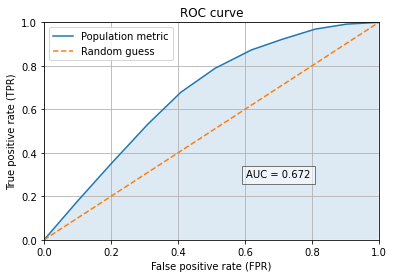

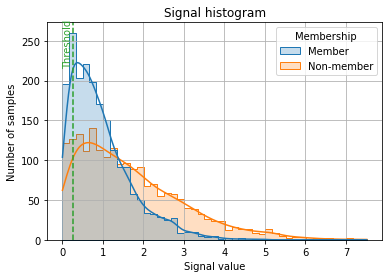

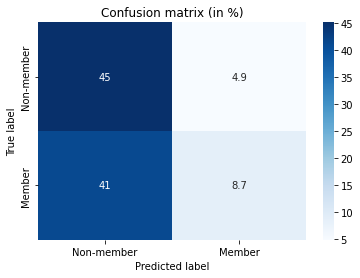

63/63 [==============================] - 5s 27ms/step - loss: 1.6825 - accuracy: 0.4070


0.40700000524520874

<Figure size 432x288 with 0 Axes>

In [ ]:
target_model = TensorflowModel(model_obj=model, loss_fn=loss_fn)
target_info_source = InformationSource(models=[target_model], datasets=[target_dataset])
reference_info_source = InformationSource(models=[target_model],datasets=[reference_dataset])

audit_obj = Audit(
    metrics=MetricEnum.POPULATION,
    inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
    target_info_sources=target_info_source,
    reference_info_sources=reference_info_source,
    fpr_tolerances=fpr_tolerance_list
)
audit_obj.prepare()
audit_results = audit_obj.run()[0]

for result in audit_results:
    print(result)
    
# This instruction won't be needed once the tool is on pip
from privacy_meter import audit_report
import os
audit_report.REPORT_FILES_DIR = os.path.abspath('.') 
ROCCurveReport.generate_report(metric_result=audit_results,
                               inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                               show=True
                              )
SignalHistogramReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )
ConfusionMatrixReport.generate_report(metric_result=audit_results[1],
                                      inference_game_type=InferenceGame.PRIVACY_LOSS_MODEL,
                                      show=True
                                     )

loss, acc = model.evaluate(x_test, y_test)
acc